<a href="https://colab.research.google.com/github/AREAGAM/upgraded-adventure/blob/main/nosie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon
from PIL import Image
!sudo apt-get install libportaudio2
!pip install sounddevice
!apt noise

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [3]:
size = 1024
n = 256
map_seed = 762345

In [4]:
np.random.seed(map_seed)

In [11]:
def voronoi(points, size):
    # Add points at edges to eliminate infinite ridges
    edge_points = size*np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])
    new_points = np.vstack([points, edge_points])
    
    # Calculate Voronoi tessellation
    vor = Voronoi(new_points)
    
    return vor

def voronoi_map(vor, size):
    # Calculate Voronoi map
    vor_map = np.zeros((size, size), dtype=np.uint32)

    for i, region in enumerate(vor.regions):
        # Skip empty regions and infinte ridge regions
        if len(region) == 0 or -1 in region: continue
        # Get polygon vertices    
        x, y = np.array([vor.vertices[i][::-1] for i in region]).T
        # Get pixels inside polygon
        rr, cc = polygon(x, y)
        # Remove pixels out of image bounds
        in_box = np.where((0 <= rr) & (rr < size) & (0 <= cc) & (cc < size))
        rr, cc = rr[in_box], cc[in_box]
        # Paint image
        vor_map[rr, cc] = i

    return vor_map

In [12]:
points = np.random.randint(0, size, (514, 2))
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

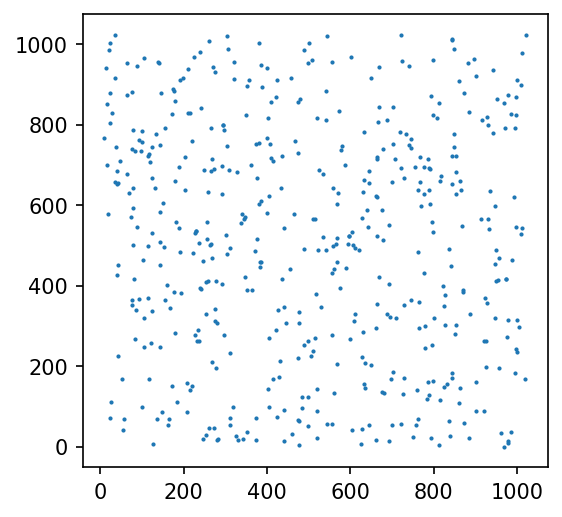

In [13]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

In [14]:
def relax(points, size, k=10):  
    new_points = points.copy()
    for _ in range(k):
        vor = voronoi(new_points, size)
        new_points = []
        for i, region in enumerate(vor.regions):
            if len(region) == 0 or -1 in region: continue
            poly = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis=0)
            new_points.append(center)
        new_points = np.array(new_points).clip(0, size)
    return new_points

In [15]:
points = relax(points, size, k=100)
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

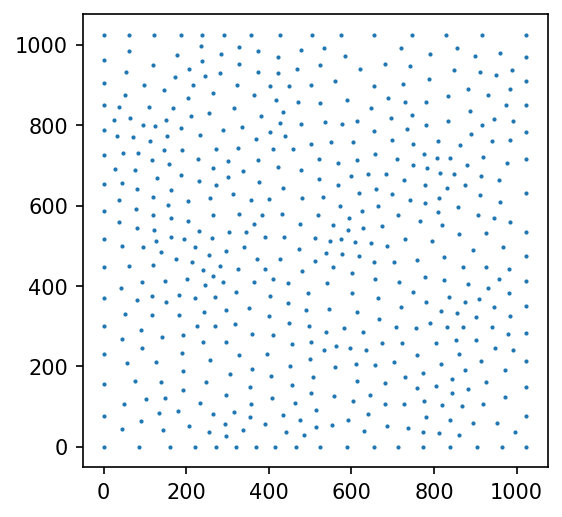

In [16]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

In [19]:
def noise_map(size, res, seed, octaves=1, persistence=0.5, lacunarity=2.0):
    scale = size/res
    return np.array([[
        snoise3(
            (x+0.1)/scale,
            y/scale,
            seed+map_seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        )
        for x in range(size)]
        for y in range(size)
    ])

In [18]:
boundary_displacement = 8
boundary_noise = np.dstack([noise_map(size, 32, 200, octaves=8), noise_map(size, 32, 250, octaves=8)])
boundary_noise = np.indices((size, size)).T + boundary_displacement*boundary_noise
boundary_noise = boundary_noise.clip(0, size-1).astype(np.uint32)

blurred_vor_map = np.zeros_like(vor_map)

for x in range(size):
    for y in range(size):
        j, i = boundary_noise[x, y]
        blurred_vor_map[x, y] = vor_map[i, j]

NameError: ignored